In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfpl = tfp.layers

2023-04-30 19:41:38.279480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import h5py
import copy

In [3]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

In [4]:
def getdataerror(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((
                    mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    mag_err_u_lsst, 
                    mag_err_g_lsst, 
                    mag_err_r_lsst, 
                    mag_err_i_lsst, 
                    mag_err_z_lsst,
                    mag_err_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:6]
    errors = datacut[:,6:-1]
    targets = datacut[:,-1]
    return features,errors,targets    

https://www.youtube.com/watch?v=KJxmC5GCWe4

TFP docs are [here](https://www.tensorflow.org/probability/api_docs/python/tfp)

In [5]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [6]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [7]:
x_train0,x_train_error0,y_train = getdataerror(hftrain)
x_test0,x_test_error0,y_test = getdataerror(hftest)

In [8]:
NBANDS = x_train0.shape[1]
NSAMPLES = x_train0.shape[0]
NSIM= 1

In [9]:
def simulatesamples(x,ex,nsim=NSIM):
    nsamples = x.shape[0]
    nbands = x.shape[1]
    
    all_samples = np.zeros((nsamples,nbands,nsim))
    for idx in range(nbands):
        mean = x[:,idx]
        sig = ex[:,idx]
        simdata = np.random.normal(mean, sig, (nsim,nsamples))
        all_samples[:,idx,: ] = simdata.T
    return all_samples  

In [10]:
train_data = simulatesamples(x_train0,x_train_error0,NSIM)
test_data = simulatesamples(x_test0,x_test_error0,NSIM)

### Data normalisation

In [11]:
mean = np.mean(train_data[:,:,0],axis=0)
std  = np.std(train_data[:,:,0],axis=0)

In [12]:
x_train0_norm = (x_train0-mean)/std
x_test0_norm = (x_test0-mean)/std

In [13]:
all_x_train_norm = []
all_x_test_norm = []
for isim in range(NSIM):
    x_train_norm = (train_data[:,:,isim] - mean)/std
    x_test_norm = (test_data[:,:,isim] - mean)/std
    all_x_train_norm.append(x_train_norm) 
    all_x_test_norm.append(x_test_norm) 

In [14]:
all_x_train_norm[0].shape

(9511, 6)

In [15]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
y_train = copy.deepcopy(y_train[:,np.newaxis])
y_test = copy.deepcopy(y_test[:,np.newaxis])

In [16]:
x_train.shape

(9511, 6)

#### 2.1.2 Simple model

In [17]:
# Let's build a simple linear regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(6,))
])

# Compile 
model.compile(loss='mse', optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=500, verbose=0)

In [18]:
[print(np.squeeze(w.numpy())) for w in model.weights];

[-0.03821775  0.07135918 -0.43056715  1.0292926   0.12480715 -0.578681  ]
0.94510376


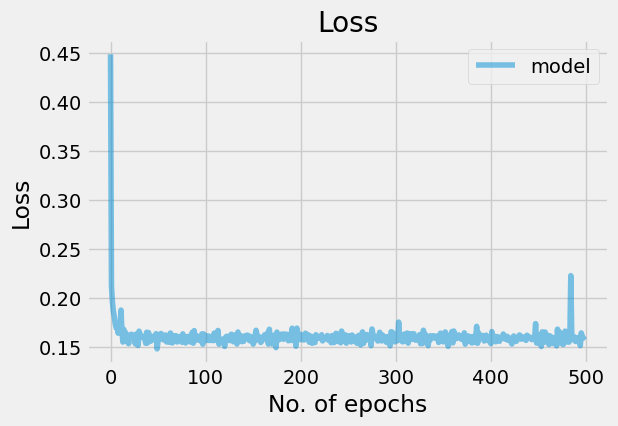

In [19]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='model', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Predict
y_pred_test = model(x_test)
y_pred_train = model(x_train)

In [21]:
y_pred_test

<tf.Tensor: shape=(18960, 1), dtype=float32, numpy=
array([[0.15201831],
       [0.20499587],
       [0.05148757],
       ...,
       [1.1618459 ],
       [0.9595207 ],
       [1.0647452 ]], dtype=float32)>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


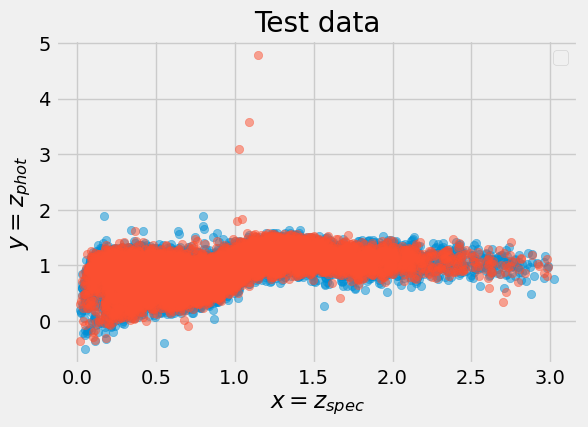

In [22]:
# Plot the data and a trained regression line
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.scatter(y_train, y_pred_train, alpha=.5)
plt.xlabel('$x = z_{spec}$')
plt.ylabel('$y = z_{phot}$')
plt.title('Test data')
plt.legend()
plt.show()

#### 2.1.3 Model with probabilistic output - aleatoric uncertainty (learn mean & std)

In [23]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
#y_train = copy.deepcopy(y_train[:,np.newaxis])
#y_test = copy.deepcopy(y_test[:,np.newaxis])

In [24]:
x_train.shape

(9511, 6)

In [25]:
np.argwhere(np.isnan(x_train))

array([], shape=(0, 2), dtype=int64)

In [26]:
np.argwhere(np.isnan(x_test))

array([], shape=(0, 2), dtype=int64)

In [27]:
# Let's build a model with probabilistic output (mean & std) - a simple way
event_shape = 1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(6,)),
    tfpl.IndependentNormal(event_shape=event_shape)
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)



# Compile 
model.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs = 1000, verbose=0)

In [28]:
[print(np.squeeze(w.numpy())) for w in model.weights];

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[nan nan]


In [29]:
# Let's compare distributions - y_train & y_model
y_model_test = model(x_test).sample().numpy()
y_model_train = model(x_train).sample().numpy()

In [30]:
y_model_test

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

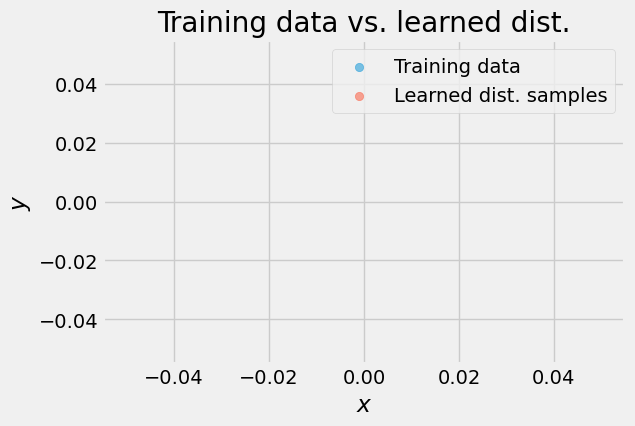

In [31]:
# Plot 
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_model_train, alpha=.5, label='Training data')
plt.scatter(y_test, y_model_test, alpha=.5, label='Learned dist. samples')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Training data vs. learned dist.')
plt.show()

ValueError: x and y must be the same size

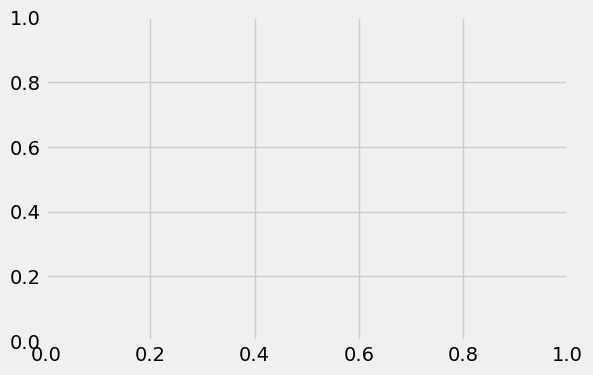

In [32]:
# Compute conf ints
y_sample = model(x_train).sample()
y_hat = model(x_train).mean()
y_sd = model(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_hat, label='Fitted reg. line', c='r')
plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.1, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line\n+ 95% CIs')
plt.legend()
plt.show()

## 3. Modeling epistemic uncertainty - `tfpl.DenseVariational`

Now, we're going to model weight's uncertainty. 

This means, that each weight in our network will now be represented by a **distribution**, and **not** just a **point estimate**.

<br><br>

<img src="https://sanjaykthakur.files.wordpress.com/2018/12/bayes_nn.png">
<p style="text-align: center"><sup>Image from <a href="https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/">https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/</a></sup></p>

<br><br>

To do this we'll use **Bayes by Backprop** method introduced in a Blundell et al. paper [Weight uncertainty in neural networks](https://arxiv.org/pdf/1505.05424.pdf) (2015).

<br>

We'll try to estimate weight distribution parameters $\theta$, given data $D$:


$$\large P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$


We'll follow a three-step formula to achieve this:

1. Pick a prior density over weights $P(\theta)$
2. Use training data $D$ to determine the likelihood $P(D | \theta)$
3. Estimate the posterior density over weights $P(\theta | D)$ 

<br>

Keywords: [***KL divergence***](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [***ELBO***](https://en.wikipedia.org/wiki/Evidence_lower_bound), [***reparametrization trick***](https://arxiv.org/pdf/1505.05424.pdf)

### 3.1 Epistemic uncertainty - linear case

In [33]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
#y_train = copy.deepcopy(y_train[:,np.newaxis])
#y_test = copy.deepcopy(y_test[:,np.newaxis])

In [34]:
y_train.shape

(9511, 1)

In [35]:
# Let's start with our linear data!
x_train_100 = x_train[:100,:]
x_train_1000 = x_train[:1000,:]

y_train_100 = y_train[:100,:]
y_train_1000 = y_train[:1000,:]

y_train_100 = y_train[:100,:]
y_train_1000 = y_train[:1000,:]

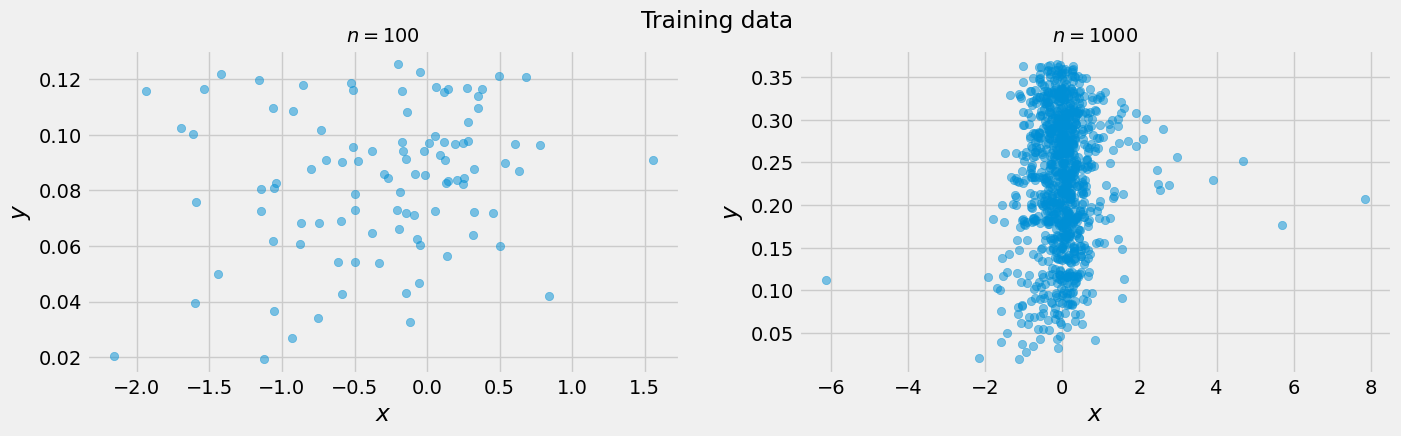

In [36]:
# Plot the data
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.scatter(x_train_100[:,0], y_train_100[:,0], alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)

plt.subplot(122)
plt.scatter(x_train_1000[:,0], y_train_1000[:,0], alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)

plt.suptitle('Training data')
plt.show()

#### 3.1.1 Define prior and posterior

`prior()` and `posterior()` functions are necessary to parametrize `tfpl.DenseVariational` layer.

They both need to take `kernel_size`, `bias_size` and `dtype` arguments.

In [37]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

#### 3.1.2 Aleatoric uncertainty - define a model with `DenseVariational` layer

In [38]:
# Define the model
def get_aleatoric_model(x_train_shape):
    
    model = tf.keras.Sequential([
        tfpl.DenseVariational(
            1,
            input_shape=(6,),
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1/x_train_shape, # Normalizing to scale the D_KL term in ELBO properly when using minibatches.
            kl_use_exact=False) # could be `True` in this case, but we go for estimated value
    ])

    # Compile
    model.compile(loss='mse', optimizer='sgd')
    
    return model

# Initialize
model = get_aleatoric_model(100)

In [39]:
# Fit the model on two datasets 
print('Fitting `model_100`...')
model_100 = get_aleatoric_model(100)
history_100 = model_100.fit(x_train_100, y_train_100, epochs=1000, verbose=False)

print('Fitting `model_1000`...')
model_1000 = get_aleatoric_model(1000)
history_1000 = model_1000.fit(x_train_1000, y_train_1000, epochs=1000, verbose=False)

print('Done.')

Fitting `model_100`...
Fitting `model_1000`...
Done.


In [40]:
[print(np.squeeze(w.numpy())) for w in model_100.weights];

[-8.3351264e+20 -1.8075023e+21 -2.2145612e+21 -2.1479613e+21
 -1.9985658e+21 -1.9394064e+21  1.3695763e+19 -9.7692700e+02
  2.1302077e+21 -4.1056053e+21 -2.0605836e+21  6.3711453e+20
  1.4660948e+21 -9.3185528e+20 -5.0793633e+01 -1.3310432e+09
  1.5833536e+22  7.7314049e+21 -4.7965852e+21 -6.2130343e+21
  4.5783560e+21  3.9434473e+21 -5.1661869e+01 -7.2279805e+04
  8.1071960e+21 -4.9406430e+21 -6.5443720e+21  4.6838675e+21
  5.0757352e+21 -7.5881595e+21 -2.2289024e+08 -8.1836738e+03
 -5.1770893e+21 -7.0736289e+21  4.9734551e+21]


In [41]:
[print(np.squeeze(w.numpy())) for w in model_1000.weights];

[-1.7667297e-02  3.1165123e-01 -2.5753605e-01 -6.1682980e-03
  2.9091477e-02  2.4824149e-03  1.8731262e-01 -3.3862274e+00
  1.4619261e-02  1.9937370e-02  5.1282428e-02  4.4484973e-02
 -9.9439479e-02 -1.9978950e-02 -2.7201521e+00 -3.7952449e+00
 -2.9284731e-01 -2.0992000e-02  9.3701921e-02  7.6505519e-02
 -1.4598518e-02 -3.4494530e-02 -1.1226523e+00 -1.0456299e+00
 -3.9378336e-01  2.0219384e-02  1.0072784e-01  3.0298516e-02
  1.9303443e-02 -4.7098517e-01 -8.7830991e-01 -6.9965822e-01
 -4.6265438e-01  7.1207292e-02 -3.1200440e-03]


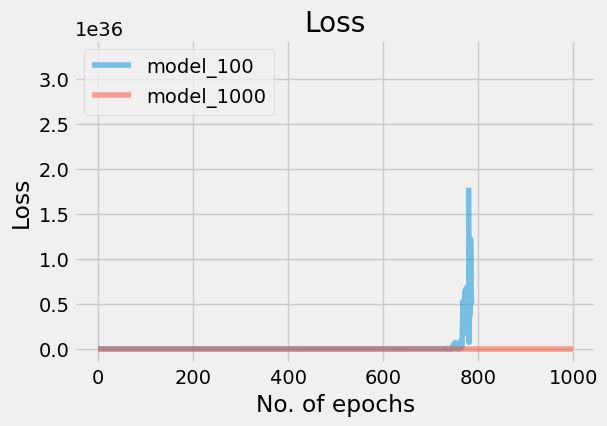

In [42]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history_100.history['loss'], label='model_100', alpha=.5)
plt.plot(history_1000.history['loss'], label='model_1000', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
y_pred_100 = model_100(x_train_100)
y_pred_1000 = model_1000(x_train_1000)

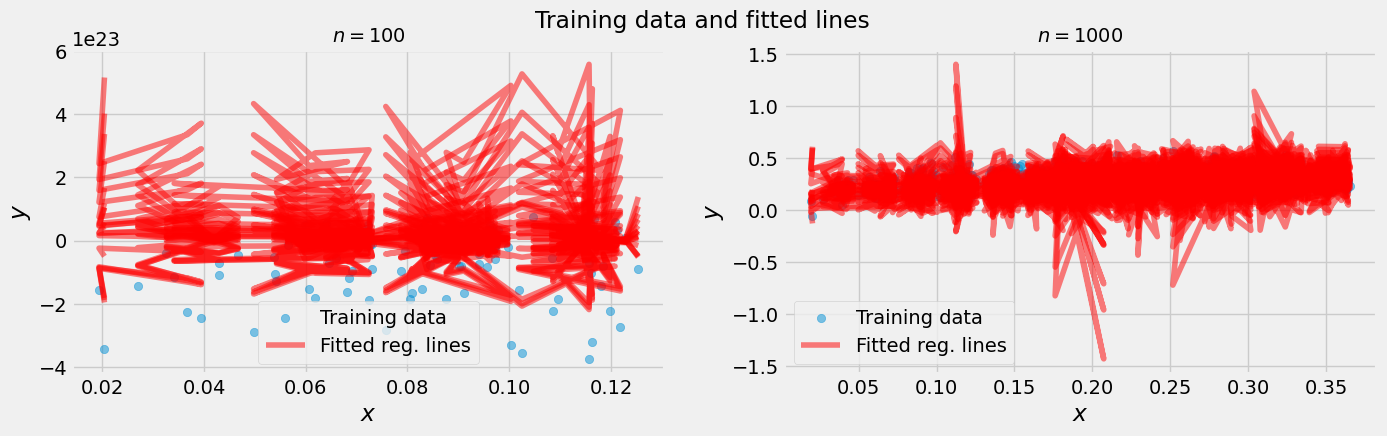

In [45]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(15, 4))

#------------------------------

plt.subplot(121)
plt.scatter(y_train_100, y_pred_100, alpha=.5, marker="o",label='Training data')
for _ in range(N_ITERS):
    y_model_100 = model_100(x_train_100)
    if _ == 0:
        plt.plot(y_train_100, y_model_100, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(y_train_100, y_model_100, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)
plt.legend()

#------------------------------

plt.subplot(122)
plt.scatter(y_train_1000, y_pred_1000, alpha=.5,marker="o" ,label='Training data')
for _ in range(N_ITERS):
    y_model_1000 = model_1000(x_train_1000)
    if _ == 0:
        plt.plot(y_train_1000, y_model_1000, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(y_train_1000, y_model_1000, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)
plt.legend()

#------------------------------

plt.suptitle('Training data and fitted lines')
plt.show()

## 4. Going fully probabilistic: aleatoric & epistemic uncertainty

### 4.1 Fully probabilistic non-linear case 

In [46]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

In [47]:
# Define the model
def get_full_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=60,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [48]:
# Get the model
n_samples = x_train.shape[0]
model_full = get_full_model(n_samples)

In [49]:
y_train.shape

(9511, 1)

In [50]:
%%time
# Initialize the model
model_full = get_full_model(n_samples)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=0)

CPU times: user 42min 51s, sys: 7min 36s, total: 50min 28s
Wall time: 22min 48s


In [51]:
[print(np.squeeze(w.numpy())) for w in model_full.weights];

[-1.0383167   0.42524248  0.4112094  ... -0.09922809  0.01070868
  0.21661228]
[ 0.545885   -0.5248183   0.71684986 ...  0.03740658 -0.00883434
 -2.2426927 ]


In [52]:
y_pred_train= model_full(x_train).sample()

In [53]:
y_pred_train.shape

TensorShape([9511, 1])

In [54]:
y_train.shape

(9511, 1)

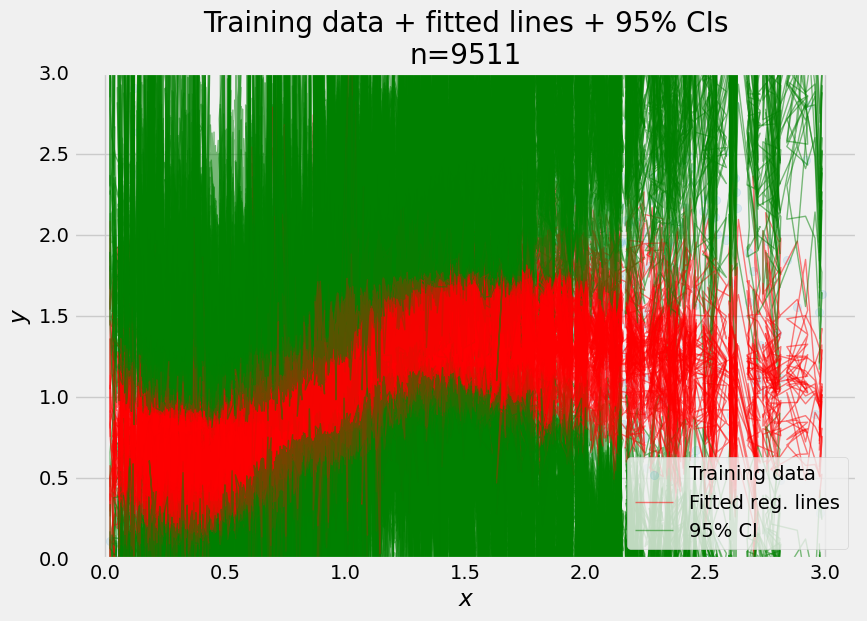

In [55]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(y_train, y_pred_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.ylim(0,3)
#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

In [60]:
# Define the model
def get_bigfull_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=64,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        tfpl.DenseVariational(units=64,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [57]:
x_train.shape

(9511, 6)

In [58]:
y_train.shape

(9511, 1)

In [ ]:
%%time
n_samples = x_train.shape[0]
# Initialize the model
model_bigfull = get_bigfull_model(n_samples)

# Fit
history = model_bigfull.fit(x_train, y_train, epochs=1000, verbose=0)

In [ ]:
model_bigfull.summary()